In [1]:
import sys
print(sys.version)

import matplotlib.pyplot as plt
#%matplotlib inline
#%config BackendInline.figure_format='svg'

plt.style.use(['seaborn-paper', 'seaborn-white'])
plt.matplotlib.rcParams['figure.dpi'] = 120
plt.matplotlib.rcParams['savefig.dpi'] = 120

import numpy as np
import pandas as pd

import mlgrad.model as model
import mlgrad.func as func
import mlgrad.regular as regular
import mlgrad.loss as loss
import mlgrad.weights as weights
import mlgrad.averager as averager

from mlgrad import averager_it, averager_fg, fg, erm_fg, irgd, erm_irgd, erisk

3.6.4 (v3.6.4:d48ecebad5, Dec 18 2017, 21:07:28) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Искусственный пример

In [2]:
def gendataset(N=100, a=2., q=0.4, dy=2.):
    M = int(q*N)
    X0 = np.linspace(0., 16., N)
    Y0 = a*X0
    Y0 += 2*dy*np.random.random(N)-dy
    X1 = a*np.random.random(M) - a
    Y1 = 3*a*np.random.random(M)
    Y1 += 30
    X2 = a*np.random.random(M) - a
    Y2 = 3*a*np.random.random(M)
    X2 += 16
    Y2 += 0
    X = np.hstack((X0, X1, X2))
    Y = np.hstack((Y0, Y1, Y2))
    Xs = X.reshape(-1,1)
    xrange = np.array(np.linspace(-a, a+15., 10)).reshape(-1,1)
    return X, Y, Xs, xrange


In [3]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())
loss_func_hub = loss.ErrorLoss(func.Huber())
loss_func_tuk = loss.ErrorLoss(func.Tukey())
loss_func_lgs = loss.ErrorLoss(func.Logistic(1.0))
loss_func_quant = loss.ErrorLoss(func.Quantile(0.5))

In [4]:
def linear_regression_gd(Xs, Y, loss_func, h=0.01, tol=1.0e-6, n_iter=5000, callback=None):
    m = Xs.shape[1] + 1
    param_init = np.array(np.random.random(m))
    lm_line = model.LinearModel(param_init)
    er = erisk(Xs, Y, lm_line, loss_func)
    alg = erm_fg(er, h=h, tol=tol, n_iter=n_iter, verbose=1, callback=callback)
    return alg

In [5]:
def plot_log(d):
    plt.figure(figsize=(15,4))
    m = len(d)
    i = 1
    for key, vals in sorted(d.items()):
        plt.subplot(1, m, i)
        k_range, u_seq = zip(*enumerate(d[key]))
        plt.plot(k_range, u_seq, marker='s', markersize=3)
        plt.grid(1)
        plt.title(key)
        plt.minorticks_on()
        i += 1
        plt.tight_layout()
    plt.show()

In [6]:
def linear_regression_pb(X, Y, line_model, loss_func, penalty_func, callback=None, h=0.01, n_iter=100):
    avrfunc = averager_it(penalty_func, tol=1.0e-6, n_iter=5000)
    #avrfunc = averager_fg(penalty_func, h=0.01, tol=1.0e-5, n_iter=5000)
    #alg_reg = regular.Square()
    er = erisk(X, Y, line_model, loss_func)
    alg_fg = fg(er, h=h, tol=1.0e-6, n_iter=5000, stop_condition='diffL2')
    alg_weights = weights.MWeights(avrfunc, er)
    #irgd_averager = averager.ArrayCyclicAverager(20)
    irgd_averager = None
    alg_irgd = erm_irgd(alg_fg, alg_weights, tol=1.0e-4, callback=callback, param_averager=irgd_averager, n_iter=n_iter)
    return alg_irgd

In [7]:
q = 0.0
dy = 2
X0, Y0, X0s, xrange  = gendataset(q=q, dy=dy)

881 [0.70464787 1.92233445]


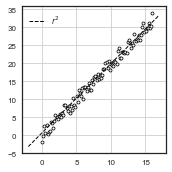

In [8]:
alg_sq = linear_regression_gd(X0s, Y0, loss_func_sq)
#alg_hub = linear_regression_gd(X1s, Y1, loss.Loss(func.Huber(3)))
#alg_quant = linear_regression_gd(X1s, Y1, loss.Loss(func.Quantile(0.5)))

plt.figure(figsize=(2.5, 2.5))
plt.scatter(X0, Y0, s=9, marker='o', c='w', edgecolors='k', linewidths=0.75) #, label='data')
plt.plot(xrange, alg_sq.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$r^2$', linestyle='--')
#plt.plot(xrange, alg_hub.model.evaluate_all(xrange), color='k', linewidth=1., label=r'M/huber', linestyle=':')
#plt.plot(xrange, alg_quant.model.evaluate_all(xrange), color='k', linewidth=1., label=r'Quantile', linestyle='-.')
plt.grid(1)
plt.minorticks_on()
#plt.xticks([],[])
#plt.yticks([],[])
#plt.xlim(-5, 20)
plt.legend()
#plt.title(r'noise: %s, outliers: %s%%' % (dy, int(200*q)))
plt.tight_layout()
plt.savefig('fig/lin_regr_outliers_0.pdf')
plt.show()

In [9]:
q = 0.10
dy = 2
X1, Y1, X1s, xrange  = gendataset(q=q, dy=dy)

5000 [8.73227898 0.84169903]
703 [0.98285775 1.87959639]
364 [1.58724942 1.68935188]


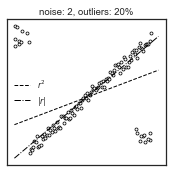

In [10]:
alg_sq = linear_regression_gd(X1s, Y1, loss_func_sq)
alg_abs = linear_regression_gd(X1s, Y1, loss_func_abs)
alg_hub = linear_regression_gd(X1s, Y1, loss_func_hub)
#alg_tuk = linear_regression_gd(X1s, Y1, loss.Loss(func.Tukey(6.)))
#alg_quant = linear_regression_gd(X1s, Y1, loss.Loss(func.Quantile(0.5)))

plt.figure(figsize=(2.5, 2.5))
plt.scatter(X1, Y1, s=9, marker='o', c='w', edgecolors='k', linewidths=0.75) #, label='data')
plt.plot(xrange, alg_sq.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$r^2$', linestyle='--')
plt.plot(xrange, alg_abs.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$|r|$', linestyle='-.')
#plt.plot(xrange, alg_hub.model.evaluate_all(xrange), color='k', linewidth=1., label=r'M/Huber', linestyle=':')
#plt.plot(xrange, alg_tuk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'M/Tukey', linestyle=':')
#plt.plot(xrange, alg_quant.model.evaluate_all(xrange), color='k', linewidth=1., label=r'Quantile', linestyle='-.')
plt.grid(1)
plt.minorticks_on()
plt.xticks([],[])
plt.yticks([],[])
#plt.xlim(-5, 20)
plt.legend()
plt.title(r'noise: %s, outliers: %s%%' % (dy, int(200*q)))
plt.tight_layout()
plt.savefig('fig/lin_regr_outliers_20.pdf')
plt.show()

In [11]:
q = 0.25
dy = 2
X2, Y2, X2s, xrange  = gendataset(q=q, dy=dy)
alpha = 0.005

In [12]:
d2 = {"u":[],"param":[], "K":[], "Ka":[], "lval":[], "pval":[]}
def callback2(alg, d=d2):
    d["u"].append(alg.weights.average.u)
    d["K"].append(alg.gd.K)
    d["lval"].append(alg.gd.risk.lval)
    d["Ka"].append(alg.weights.average.K)
    d["pval"].append(alg.weights.average.pval)
    d["param"].append(alg.gd.risk.model.param.base.copy())


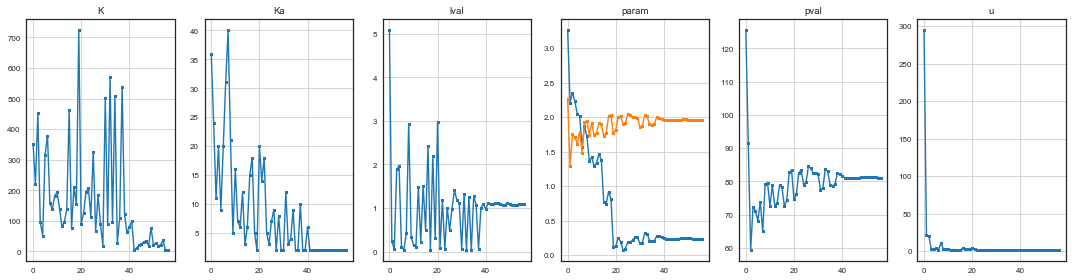

In [13]:
alpha=0.001
penalty_func_sq2 = func.Quantile_AlphaLog(alpha, 0.5)
#penalty_func_sq2 = func.Sqrt(alpha)

#param_init2 = np.random.random((2,))
param_init4 = np.array([0.,-1.])
lm_line4 = model.LinearModel(param_init4)

alg_irgd2 = linear_regression_pb(X2s, Y2, lm_line4, loss_func_sq, penalty_func_sq2, callback=callback2, h=0.02)

# irgd2_avrfunc = averager_fg(penalty_func_sq2, h=0.01, n_iter=5000)
# irgd2_fg = fg(lm_line4, loss_func_sq, h=0.001, n_iter=5000)
# irgd2_weights = weights.MWeights(irgd2_avrfunc, irgd2_fg)
# #irgd2_averager = averager.ArrayCyclicAverager(20)
# alg_irgd2 = erm_irgd(X2s, Y2, irgd2_fg, irgd2_weights, param_averager=None, callback=callback2)

plot_log(d2)

468 [18.90427372 -0.31751362]
489 [13.99802854  0.27886865]
330 [8.83193142 1.04239094]


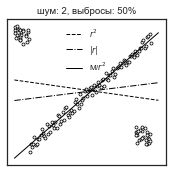

In [14]:
alg_sq = linear_regression_gd(X2s, Y2, loss_func_sq, h=0.2)
alg_abs = linear_regression_gd(X2s, Y2, loss_func_abs, h=0.2)
alg_hub = linear_regression_gd(X2s, Y2, loss_func_hub, h=0.1)
loss_func_tuk = loss.ErrorLoss(func.Tukey(6.))
#alg_tuk = linear_regression_gd(X2s, Y2, loss_func_tuk, h=0.1)
#alg_quant = linear_regression_gd(X2s, Y2, loss.Loss(func.Quantile(0.5)))

plt.figure(figsize=(2.5,2.5))
plt.scatter(X2, Y2, s=9, marker='o', c='w', edgecolors='k', linewidths=0.75) #, label='data')
plt.plot(xrange, alg_sq.risk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'$r^2$', linestyle='--')
plt.plot(xrange, alg_abs.risk.model.evaluate_all(xrange), color='k', linewidth=1., label='$|r|$', linestyle='-.')
#plt.plot(xrange, alg_tuk.model.evaluate_all(xrange), color='k', linewidth=1., label=r'Tukey', linestyle=':')
#plt.plot(xrange, alg_quant.model.evaluate_all(xrange), color='k', linewidth=1., label=r'Quantile', linestyle='-.')
plt.plot(xrange, alg_irgd2.gd.risk.model.evaluate_all(xrange), color='k', linewidth=1., label='M/$r^2$', linestyle='-')
plt.grid(1)
plt.minorticks_on()
plt.xticks([],[])
plt.yticks([],[])
#plt.xlim(-5, 20)
plt.legend()
plt.title(r'шум: %s, выбросы: %s%%' % (dy, int(200*q)))
plt.tight_layout()
plt.savefig('fig/lin_regr_outliers_M_50.pdf')
plt.show()

In [15]:
q = 0.4
dy = 2
X3, Y3, X3s, xrange  = gendataset(q=q, dy=dy)

In [16]:
penalty_func = func.Quantile_AlphaLog(0.01, 0.8)
penalty_func

In [17]:
alg_s = linear_regression_gd(X3s, Y3, loss_func_sq, h=0.5)
alg_a = linear_regression_gd(X3s, Y3, loss_func_abs)
alg_h = linear_regression_gd(X3s, Y3, loss_func_hub)
alg_t = linear_regression_gd(X3s, Y3, loss_func_tuk)
alg_l = linear_regression_gd(X3s, Y3, loss_func_lgs, h=0.05)
alg_q = linear_regression_gd(X3s, Y3, loss.ErrorLoss(func.Quantile(0.51)))

308 [24.32147828 -0.90611418]
5000 [ 9.96842142 -0.05237807]
5000 [10.22675784 -0.09492568]
5000 [8.45194152 0.28806523]
1244 [29.19605707 -1.5865541 ]
5000 [ 9.70416423 -0.1787065 ]


In [18]:

d = {"u":[],"param":[], "K":[], "Ka":[], "lval":[], "pval":[]}
def callback(alg, d=d):
    d["u"].append(alg.weights.average.u)
    d["K"].append(alg.gd.K)
    d["pval"].append(alg.weights.average.pval)
    d["lval"].append(alg.gd.risk.lval)
    d["Ka"].append(alg.weights.average.K)
    d["param"].append(alg.gd.risk.model.param.base.copy())


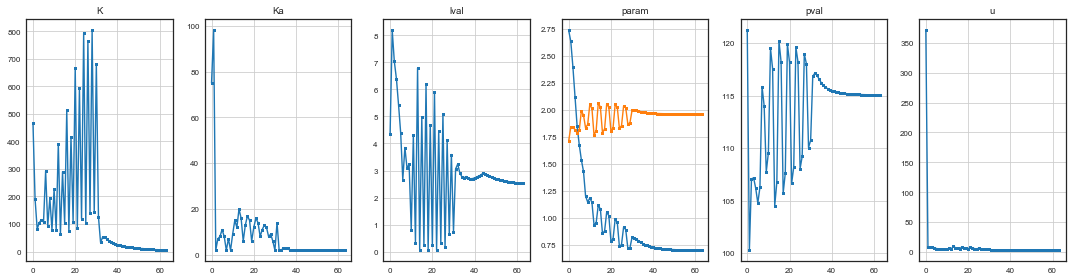

In [19]:
alpha=0.1
#loss_func_sq = loss.Loss(func.Square())
penalty_func_sq = func.Quantile_AlphaLog(alpha, 0.54)
#penalty_func_sq = func.Sqrt(alpha)

#param_init2 = np.random.random((2,))
param_init2 = np.array([0.,-1.])
lm_line2 = model.LinearModel(param_init2)

# irgd_avrfunc = averager_fg(penalty_func_sq, h=0.01, tol=1.0e-6)
# irgd_fg = fg(lm_line2, loss_func_sq, h=0.01, tol=1.0e-6)
# irgd_weights = weights.MWeights(irgd_avrfunc, irgd_fg)
# #irgd_averager = averager.ArrayCyclicAverager(20)
# irgd_averager = None

# alg_irgd = erm_irgd(X3s, Y3, irgd_fg, irgd_weights, param_averager=irgd_averager, callback=callback)

alg_irgd = linear_regression_pb(X3s, Y3, lm_line2, loss_func_sq, penalty_func_sq, callback=callback)

plot_log(d)

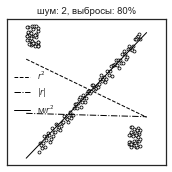

In [20]:
#plt.figure(figsize=(3.5, 3))
plt.figure(figsize=(2.5, 2.5))
plt.title(r'шум: %s, выбросы: %s%%' % (dy, int(200*q)))
plt.scatter(X3, Y3, s=9, marker='o', c='w', edgecolors='k', linewidths=0.75)
plt.grid(1)
plt.minorticks_on()
#plt.plot(xrange, lm_line2.evaluate_all(xrange), color='k', linewidth=1., label=r'LQS$_\alpha$ (0.5)')
#plt.plot(xrange, lm_line3.evaluate_all(xrange), color='k', linewidth=1.0, label=r'M${\sqrt{1+r^2}}-1:|r|$')
plt.plot(xrange, alg_s.risk.model.evaluate_all(xrange), color='k', linewidth=1., linestyle='--', label=r'$r^2$')
plt.plot(xrange, alg_a.risk.model.evaluate_all(xrange), color='k', linewidth=1., linestyle='-.', label=r'$|r|$')
#plt.plot(xrange, alg_h.model.evaluate_all(xrange), color='k', linewidth=1., linestyle=':', label='Huber')
#plt.plot(xrange, alg_t.model.evaluate_all(xrange), color='k', linewidth=1., linestyle=':', label='Tukey')
#plt.plot(xrange, alg_l.model.evaluate_all(xrange), color='k', linewidth=1., linestyle='-', marker='s', label='Logistic')
#plt.plot(xrange, alg_q.model.evaluate_all(xrange), color='k', linewidth=1., linestyle='-.', label=r'LQ$_\alpha$ 0.51')
plt.plot(xrange, alg_irgd.gd.risk.model.evaluate_all(xrange), color='k', linewidth=1., label='M/$r^2$', linestyle='-')
plt.xlim(-5, 20)
plt.legend(loc='best')
plt.xticks([],[])
plt.yticks([],[])
plt.tight_layout()
plt.savefig('fig/lin_regr_outliers_M_80.pdf')
plt.show()